# Nhập thư viện


In [22]:
import os, time, math, random, requests
import pandas as pd
from datetime import datetime, timezone, timedelta
from tqdm import tqdm
from pytrends.request import TrendReq
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pywaffle import Waffle
from sklearn.preprocessing import MinMaxScaler

# Lấy và xử lý dữ liệu

Setup

In [162]:
# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2025-07-01"       # ngày bắt đầu
END_DATE = datetime.today().strftime("%Y-%m-%d")       # ngày kết thúc

## Lấy file dữ liệu BTC


In [163]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BTC"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BTC (BTCUSDT) từ 2025-07-01 → 2025-10-29, interval=1d


In [164]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [165]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [166]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [167]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [168]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [169]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [170]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [171]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 121 dòng
klines rows: 121
Fetching funding rates...
funding rows: 121
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2824 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2824
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\BTC\google_trend_BTC.csv
✅ Saved CSV: data\BTC\dataset_BTC_20250701_20251029.csv
✅ Saved XLSX: data\BTC\dataset_BTC_20250701_20251029.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2025-07-01,107087.3,107499.9,105182.6,105637.9,120434.401,BTC,1.279897e+10,2043731,0.000022,64.0,<NA>,NaN,NaN,NaN,31,1d
1,2025-07-02,105637.9,109690.4,105010.0,108800.0,177567.261,BTC,1.917964e+10,2621458,0.000031,63.0,<NA>,8.895480e+08,366147.0,5.280341e+07,33,1d
2,2025-07-03,108800.0,110484.0,108480.6,109545.2,141487.997,BTC,1.549233e+10,2342574,0.000045,73.0,<NA>,NaN,NaN,NaN,35,1d
3,2025-07-04,109545.1,109732.3,107200.0,107935.4,132305.847,BTC,1.431642e+10,1957162,0.000040,73.0,<NA>,NaN,NaN,NaN,33,1d
4,2025-07-05,107935.3,108368.1,107688.3,108153.4,36660.948,BTC,3.960654e+09,734951,0.000027,67.0,<NA>,9.128041e+08,427456.0,5.345322e+07,30,1d
5,2025-07-06,108153.4,109684.7,107743.4,109145.8,72388.603,BTC,7.864421e+09,1278877,0.000015,66.0,<NA>,NaN,NaN,NaN,30,1d
6,2025-07-07,109145.8,109667.3,107456.0,108203.9,106397.578,BTC,1.153668e+10,1788546,0.000034,73.0,<NA>,NaN,NaN,NaN,35,1d
7,2025-07-08,108203.9,109180.0,107400.0,108873.1,95156.027,BTC,1.032033e+10,1658291,0.000031,65.0,<NA>,8.255936e+08,354753.0,4.937527e+07,32,1d
8,2025-07-09,108873.2,112036.8,108273.5,111199.9,167834.731,BTC,1.845820e+10,2548622,0.000036,66.0,<NA>,NaN,NaN,NaN,35,1d
9,2025-07-10,111199.8,117500.0,110432.2,115979.2,225570.213,BTC,2.557372e+10,3420723,0.000068,71.0,<NA>,NaN,NaN,NaN,53,1d


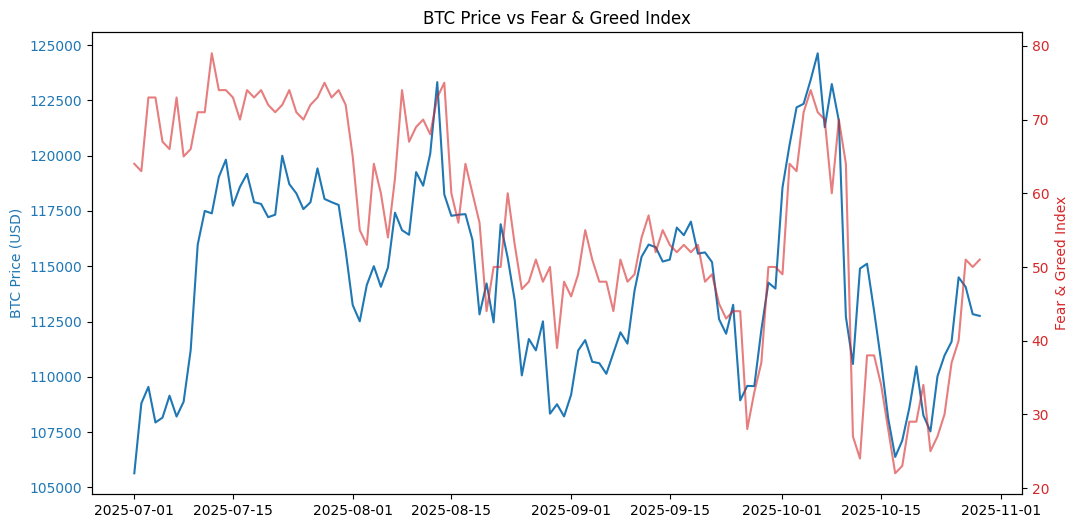

In [172]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [173]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_20250701_20251029.csv
📏 121 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,107087.3,107499.9,105182.6,105637.9,120434.401,BTC,1.279897e+10,2043731,0.000022,...,NaN,9.565687e+08,452266.114286,5.439404e+07,31,1d,NaN,NaN,0.000000,50.8
1,2025-07-02,105637.9,109690.4,105010.0,108800.0,177567.261,BTC,1.917964e+10,2621458,0.000031,...,NaN,8.895480e+08,366147.000000,5.280341e+07,33,1d,2.993339,0.029494,0.166509,51.0
2,2025-07-03,108800.0,110484.0,108480.6,109545.2,141487.997,BTC,1.549233e+10,2342574,0.000045,...,NaN,9.565687e+08,452266.114286,5.439404e+07,35,1d,0.684926,0.006826,0.205749,57.8
3,2025-07-04,109545.1,109732.3,107200.0,107935.4,132305.847,BTC,1.431642e+10,1957162,0.000040,...,NaN,9.565687e+08,452266.114286,5.439404e+07,33,1d,-1.469530,-0.014804,0.120981,57.0
4,2025-07-05,107935.3,108368.1,107688.3,108153.4,36660.948,BTC,3.960654e+09,734951,0.000027,...,NaN,9.128041e+08,427456.000000,5.345322e+07,30,1d,0.201973,0.002018,0.132460,52.2


In [150]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_clean.csv
📏 121 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,107087.3,107499.9,105182.6,105637.9,120434.401,BTC,1.279897e+10,2043731,0.000022,...,NaN,9.565687e+08,452266.114286,5.439404e+07,31,1d,NaN,NaN,0.000000,50.8
1,2025-07-02,105637.9,109690.4,105010.0,108800.0,177567.261,BTC,1.917964e+10,2621458,0.000031,...,NaN,8.895480e+08,366147.000000,5.280341e+07,33,1d,2.993339,0.029494,0.166509,51.0
2,2025-07-03,108800.0,110484.0,108480.6,109545.2,141487.997,BTC,1.549233e+10,2342574,0.000045,...,NaN,9.565687e+08,452266.114286,5.439404e+07,35,1d,0.684926,0.006826,0.205749,57.8
3,2025-07-04,109545.1,109732.3,107200.0,107935.4,132305.847,BTC,1.431642e+10,1957162,0.000040,...,NaN,9.565687e+08,452266.114286,5.439404e+07,33,1d,-1.469530,-0.014804,0.120981,57.0
4,2025-07-05,107935.3,108368.1,107688.3,108153.4,36660.948,BTC,3.960654e+09,734951,0.000027,...,NaN,9.128041e+08,427456.000000,5.345322e+07,30,1d,0.201973,0.002018,0.132460,52.2


## Lấy file dữ liệu ETH


In [182]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "ETH"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho ETH (ETHUSDT) từ 2025-07-01 → 2025-10-29, interval=1d


In [183]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [184]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [185]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [186]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [187]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [188]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [189]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [190]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 121 dòng
klines rows: 121
Fetching funding rates...
funding rows: 121
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2824 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2824
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\ETH\google_trend_ETH.csv
✅ Saved CSV: data\ETH\dataset_ETH_20250701_20251029.csv
✅ Saved XLSX: data\ETH\dataset_ETH_20250701_20251029.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2025-07-01,2484.30,2499.60,2383.33,2403.65,4506176.030,ETH,1.098251e+10,3555794,0.000028,64.0,<NA>,NaN,NaN,NaN,9,1d
1,2025-07-02,2403.66,2618.20,2367.53,2569.37,6609066.769,ETH,1.655477e+10,4861645,0.000040,63.0,<NA>,8.895480e+08,366147.0,5.280341e+07,9,1d
2,2025-07-03,2569.37,2635.00,2555.25,2590.17,5268757.244,ETH,1.364719e+10,4325630,0.000081,73.0,<NA>,NaN,NaN,NaN,10,1d
3,2025-07-04,2590.18,2601.96,2473.07,2506.86,5033671.720,ETH,1.272539e+10,4057479,0.000036,73.0,<NA>,NaN,NaN,NaN,9,1d
4,2025-07-05,2506.87,2528.86,2486.31,2515.25,2011813.011,ETH,5.052103e+09,1961577,0.000036,67.0,<NA>,9.128041e+08,427456.0,5.345322e+07,7,1d
5,2025-07-06,2515.25,2607.08,2502.25,2569.14,3600165.163,ETH,9.172986e+09,2976116,0.000062,66.0,<NA>,NaN,NaN,NaN,8,1d
6,2025-07-07,2569.14,2589.88,2505.37,2541.37,4567857.773,ETH,1.164445e+10,3841371,0.000057,73.0,<NA>,NaN,NaN,NaN,10,1d
7,2025-07-08,2541.36,2627.83,2522.07,2613.97,4474456.244,ETH,1.153299e+10,3704131,0.000056,65.0,<NA>,8.255936e+08,354753.0,4.937527e+07,9,1d
8,2025-07-09,2613.97,2795.73,2588.49,2767.70,7269179.795,ETH,1.947287e+10,5653754,0.000060,66.0,<NA>,NaN,NaN,NaN,11,1d
9,2025-07-10,2767.69,3010.44,2754.08,2950.62,8576372.082,ETH,2.435017e+10,7003532,0.000053,71.0,<NA>,NaN,NaN,NaN,16,1d


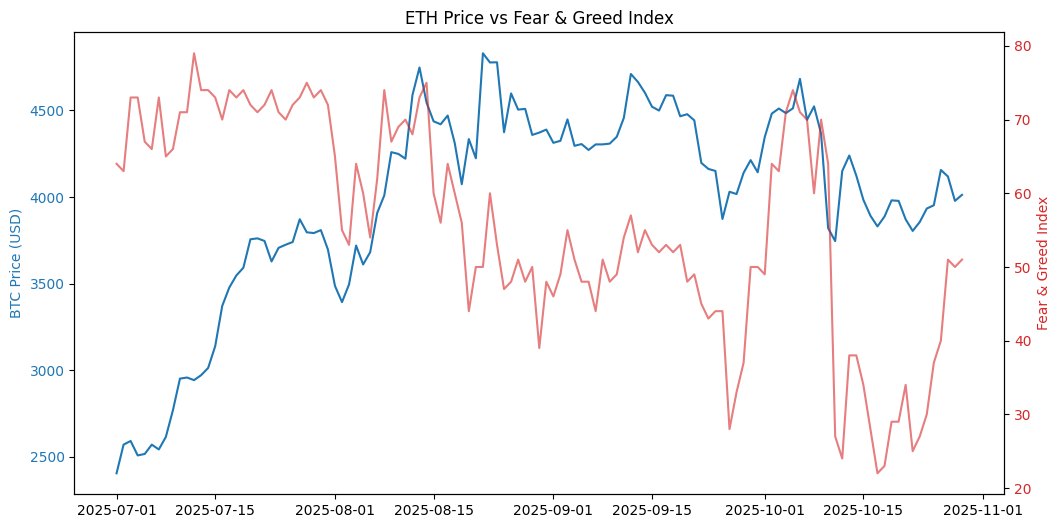

In [191]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [192]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_ETH_20250701_20251029.csv
📏 121 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\ETH\dataset_ETH_clean.csv
- data\ETH\dataset_ETH_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,2484.30,2499.60,2383.33,2403.65,4506176.030,ETH,1.098251e+10,3555794,0.000028,...,NaN,9.565687e+08,452266.114286,5.439404e+07,9,1d,NaN,NaN,0.000000,42.0
1,2025-07-02,2403.66,2618.20,2367.53,2569.37,6609066.769,ETH,1.655477e+10,4861645,0.000040,...,NaN,8.895480e+08,366147.000000,5.280341e+07,9,1d,6.894515,0.066672,0.068290,41.4
2,2025-07-03,2569.37,2635.00,2555.25,2590.17,5268757.244,ETH,1.364719e+10,4325630,0.000081,...,NaN,9.565687e+08,452266.114286,5.439404e+07,10,1d,0.809537,0.008063,0.076861,47.8
3,2025-07-04,2590.18,2601.96,2473.07,2506.86,5033671.720,ETH,1.272539e+10,4057479,0.000036,...,NaN,9.565687e+08,452266.114286,5.439404e+07,9,1d,-3.216391,-0.032693,0.042531,47.4
4,2025-07-05,2506.87,2528.86,2486.31,2515.25,2011813.011,ETH,5.052103e+09,1961577,0.000036,...,NaN,9.128041e+08,427456.000000,5.345322e+07,7,1d,0.334682,0.003341,0.045988,43.0


In [193]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_ETH_clean.csv
📏 121 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\ETH\dataset_ETH_clean.csv
- data\ETH\dataset_ETH_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,2484.30,2499.60,2383.33,2403.65,4506176.030,ETH,1.098251e+10,3555794,0.000028,...,NaN,9.565687e+08,452266.114286,5.439404e+07,9,1d,NaN,NaN,0.000000,42.0
1,2025-07-02,2403.66,2618.20,2367.53,2569.37,6609066.769,ETH,1.655477e+10,4861645,0.000040,...,NaN,8.895480e+08,366147.000000,5.280341e+07,9,1d,6.894515,0.066672,0.068290,41.4
2,2025-07-03,2569.37,2635.00,2555.25,2590.17,5268757.244,ETH,1.364719e+10,4325630,0.000081,...,NaN,9.565687e+08,452266.114286,5.439404e+07,10,1d,0.809537,0.008063,0.076861,47.8
3,2025-07-04,2590.18,2601.96,2473.07,2506.86,5033671.720,ETH,1.272539e+10,4057479,0.000036,...,NaN,9.565687e+08,452266.114286,5.439404e+07,9,1d,-3.216391,-0.032693,0.042531,47.4
4,2025-07-05,2506.87,2528.86,2486.31,2515.25,2011813.011,ETH,5.052103e+09,1961577,0.000036,...,NaN,9.128041e+08,427456.000000,5.345322e+07,7,1d,0.334682,0.003341,0.045988,43.0


## Lấy file dữ liệu BNB


In [194]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BNB"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BNB (BNBUSDT) từ 2025-07-01 → 2025-10-29, interval=1d


In [195]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [196]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [197]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [198]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [199]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [200]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [201]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [202]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 121 dòng
klines rows: 121
Fetching funding rates...
funding rows: 121
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2824 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2824
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\BNB\google_trend_BNB.csv
✅ Saved CSV: data\BNB\dataset_BNB_20250701_20251029.csv
✅ Saved XLSX: data\BNB\dataset_BNB_20250701_20251029.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2025-07-01,656.99,659.20,643.65,646.11,291724.16,BNB,1.897167e+08,473313,0.0,64.0,<NA>,NaN,NaN,NaN,65,1d
1,2025-07-02,646.12,664.88,643.50,659.97,382879.99,BNB,2.519876e+08,561589,0.0,63.0,<NA>,8.895480e+08,366147.0,5.280341e+07,62,1d
2,2025-07-03,659.96,665.00,656.56,663.90,307349.05,BNB,2.032212e+08,528793,0.0,73.0,<NA>,NaN,NaN,NaN,61,1d
3,2025-07-04,663.90,664.40,650.08,653.39,287088.14,BNB,1.884732e+08,498467,0.0,73.0,<NA>,NaN,NaN,NaN,59,1d
4,2025-07-05,653.38,656.76,651.72,655.99,151159.11,BNB,9.894586e+07,300244,0.0,67.0,<NA>,9.128041e+08,427456.0,5.345322e+07,61,1d
5,2025-07-06,656.00,664.89,653.22,663.12,285320.92,BNB,1.883886e+08,407785,0.0,66.0,<NA>,NaN,NaN,NaN,69,1d
6,2025-07-07,663.12,663.20,656.50,661.04,240143.07,BNB,1.586680e+08,402066,0.0,73.0,<NA>,NaN,NaN,NaN,75,1d
7,2025-07-08,661.05,662.64,657.24,660.52,262127.28,BNB,1.729813e+08,408104,0.0,65.0,<NA>,8.255936e+08,354753.0,4.937527e+07,68,1d
8,2025-07-09,660.52,671.94,658.41,668.88,369372.61,BNB,2.453619e+08,492907,0.0,66.0,<NA>,NaN,NaN,NaN,63,1d
9,2025-07-10,668.89,688.13,667.12,686.30,523184.88,BNB,3.535426e+08,610078,0.0,71.0,<NA>,NaN,NaN,NaN,62,1d


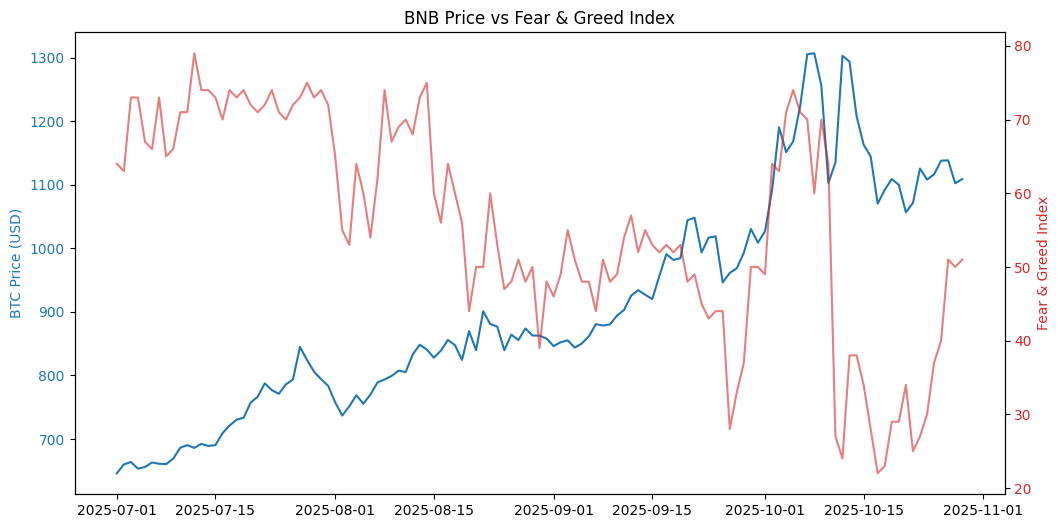

In [203]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [204]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BNB_20250701_20251029.csv
📏 121 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BNB\dataset_BNB_clean.csv
- data\BNB\dataset_BNB_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,656.99,659.20,643.65,646.11,291724.16,BNB,1.897167e+08,473313,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,65,1d,NaN,NaN,0.000000,64.4
1,2025-07-02,646.12,664.88,643.50,659.97,382879.99,BNB,2.519876e+08,561589,0.0,...,NaN,8.895480e+08,366147.000000,5.280341e+07,62,1d,2.145146,0.021225,0.020977,62.6
2,2025-07-03,659.96,665.00,656.56,663.90,307349.05,BNB,2.032212e+08,528793,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,61,1d,0.595482,0.005937,0.026925,68.2
3,2025-07-04,663.90,664.40,650.08,653.39,287088.14,BNB,1.884732e+08,498467,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,59,1d,-1.583070,-0.015957,0.011018,67.4
4,2025-07-05,653.38,656.76,651.72,655.99,151159.11,BNB,9.894586e+07,300244,0.0,...,NaN,9.128041e+08,427456.000000,5.345322e+07,61,1d,0.397925,0.003971,0.014953,64.6


In [205]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BNB_clean.csv
📏 121 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BNB\dataset_BNB_clean.csv
- data\BNB\dataset_BNB_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,656.99,659.20,643.65,646.11,291724.16,BNB,1.897167e+08,473313,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,65,1d,NaN,NaN,0.000000,64.4
1,2025-07-02,646.12,664.88,643.50,659.97,382879.99,BNB,2.519876e+08,561589,0.0,...,NaN,8.895480e+08,366147.000000,5.280341e+07,62,1d,2.145146,0.021225,0.020977,62.6
2,2025-07-03,659.96,665.00,656.56,663.90,307349.05,BNB,2.032212e+08,528793,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,61,1d,0.595482,0.005937,0.026925,68.2
3,2025-07-04,663.90,664.40,650.08,653.39,287088.14,BNB,1.884732e+08,498467,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,59,1d,-1.583070,-0.015957,0.011018,67.4
4,2025-07-05,653.38,656.76,651.72,655.99,151159.11,BNB,9.894586e+07,300244,0.0,...,NaN,9.128041e+08,427456.000000,5.345322e+07,61,1d,0.397925,0.003971,0.014953,64.6


## Lấy file dữ liệu SOL


In [206]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "SOL"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho SOL (SOLUSDT) từ 2025-07-01 → 2025-10-29, interval=1d


In [207]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [208]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [209]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [210]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [211]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [212]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [213]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [214]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 121 dòng
klines rows: 121
Fetching funding rates...
funding rows: 121
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2824 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2824
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\SOL\google_trend_SOL.csv
✅ Saved CSV: data\SOL\dataset_SOL_20250701_20251029.csv
✅ Saved XLSX: data\SOL\dataset_SOL_20250701_20251029.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2025-07-01,154.74,155.58,144.67,146.79,21960463.41,SOL,3.271666e+09,2245956,0.000023,64.0,<NA>,NaN,NaN,NaN,75,1d
1,2025-07-02,146.78,154.44,145.64,152.21,22774588.15,SOL,3.424860e+09,2314461,-0.000035,63.0,<NA>,8.895480e+08,366147.0,5.280341e+07,76,1d
2,2025-07-03,152.21,156.33,149.59,152.29,19994063.02,SOL,3.061895e+09,2132296,0.000052,73.0,<NA>,NaN,NaN,NaN,75,1d
3,2025-07-04,152.29,153.84,145.11,147.60,17734643.73,SOL,2.647166e+09,2034499,0.000008,73.0,<NA>,NaN,NaN,NaN,74,1d
4,2025-07-05,147.60,148.63,145.79,147.50,8746155.20,SOL,1.288859e+09,1124167,-0.000098,67.0,<NA>,9.128041e+08,427456.0,5.345322e+07,77,1d
5,2025-07-06,147.50,154.00,146.66,151.80,15591227.48,SOL,2.345422e+09,1711098,-0.000025,66.0,<NA>,NaN,NaN,NaN,83,1d
6,2025-07-07,151.80,153.55,147.60,148.82,18352449.44,SOL,2.766592e+09,1927982,0.000068,73.0,<NA>,NaN,NaN,NaN,81,1d
7,2025-07-08,148.82,152.83,147.75,151.59,16236679.16,SOL,2.446094e+09,1766016,-0.000002,65.0,<NA>,8.255936e+08,354753.0,4.937527e+07,75,1d
8,2025-07-09,151.59,157.90,150.44,156.99,20926187.98,SOL,3.228254e+09,2103672,0.000009,66.0,<NA>,NaN,NaN,NaN,71,1d
9,2025-07-10,157.00,165.36,155.50,164.29,23247094.55,SOL,3.706115e+09,2423176,0.000046,71.0,<NA>,NaN,NaN,NaN,74,1d


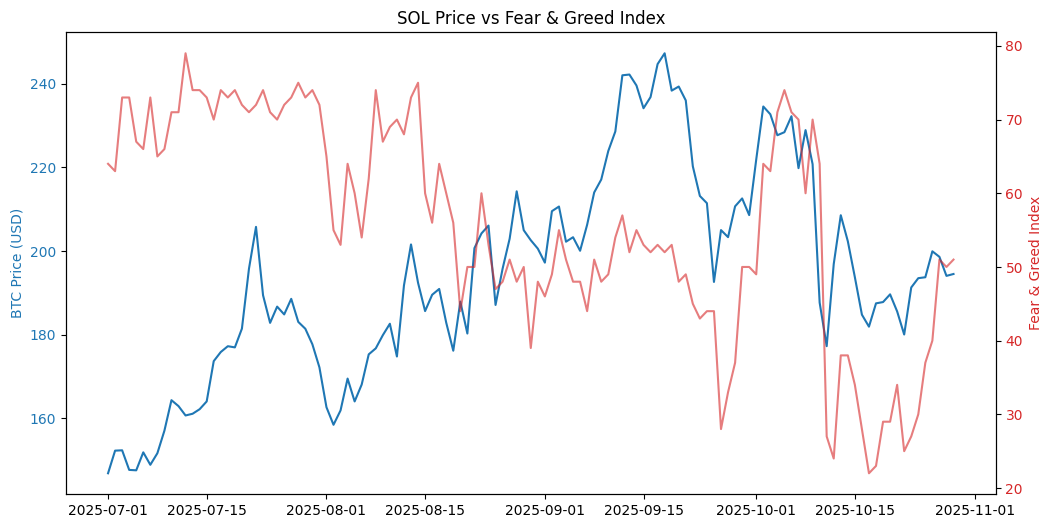

In [215]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [216]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_SOL_20250701_20251029.csv
📏 121 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\SOL\dataset_SOL_clean.csv
- data\SOL\dataset_SOL_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,154.74,155.58,144.67,146.79,21960463.41,SOL,3.271666e+09,2245956,0.000023,...,NaN,9.565687e+08,452266.114286,5.439404e+07,75,1d,NaN,NaN,0.000000,68.4
1,2025-07-02,146.78,154.44,145.64,152.21,22774588.15,SOL,3.424860e+09,2314461,-0.000035,...,NaN,8.895480e+08,366147.000000,5.280341e+07,76,1d,3.692350,0.036258,0.053904,68.2
2,2025-07-03,152.21,156.33,149.59,152.29,19994063.02,SOL,3.061895e+09,2132296,0.000052,...,NaN,9.565687e+08,452266.114286,5.439404e+07,75,1d,0.052559,0.000525,0.054699,73.8
3,2025-07-04,152.29,153.84,145.11,147.60,17734643.73,SOL,2.647166e+09,2034499,0.000008,...,NaN,9.565687e+08,452266.114286,5.439404e+07,74,1d,-3.079651,-0.031281,0.008056,73.4
4,2025-07-05,147.60,148.63,145.79,147.50,8746155.20,SOL,1.288859e+09,1124167,-0.000098,...,NaN,9.128041e+08,427456.000000,5.345322e+07,77,1d,-0.067751,-0.000678,0.007061,71.0


In [217]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_SOL_clean.csv
📏 121 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\SOL\dataset_SOL_clean.csv
- data\SOL\dataset_SOL_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,154.74,155.58,144.67,146.79,21960463.41,SOL,3.271666e+09,2245956,0.000023,...,NaN,9.565687e+08,452266.114286,5.439404e+07,75,1d,NaN,NaN,0.000000,68.4
1,2025-07-02,146.78,154.44,145.64,152.21,22774588.15,SOL,3.424860e+09,2314461,-0.000035,...,NaN,8.895480e+08,366147.000000,5.280341e+07,76,1d,3.692350,0.036258,0.053904,68.2
2,2025-07-03,152.21,156.33,149.59,152.29,19994063.02,SOL,3.061895e+09,2132296,0.000052,...,NaN,9.565687e+08,452266.114286,5.439404e+07,75,1d,0.052559,0.000525,0.054699,73.8
3,2025-07-04,152.29,153.84,145.11,147.60,17734643.73,SOL,2.647166e+09,2034499,0.000008,...,NaN,9.565687e+08,452266.114286,5.439404e+07,74,1d,-3.079651,-0.031281,0.008056,73.4
4,2025-07-05,147.60,148.63,145.79,147.50,8746155.20,SOL,1.288859e+09,1124167,-0.000098,...,NaN,9.128041e+08,427456.000000,5.345322e+07,77,1d,-0.067751,-0.000678,0.007061,71.0


## Lấy file dữ liệu XRP


In [218]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "XRP"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho XRP (XRPUSDT) từ 2025-07-01 → 2025-10-29, interval=1d


In [219]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [220]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [221]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [222]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [223]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [224]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [225]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [226]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 121 dòng
klines rows: 121
Fetching funding rates...
funding rows: 121
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2824 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2824
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\XRP\google_trend_XRP.csv
✅ Saved CSV: data\XRP\dataset_XRP_20250701_20251029.csv
✅ Saved XLSX: data\XRP\dataset_XRP_20250701_20251029.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2025-07-01,2.2358,2.2532,2.1450,2.1706,607054461.5,XRP,1.334364e+09,1928888,0.000071,64.0,<NA>,NaN,NaN,NaN,17,1d
1,2025-07-02,2.1706,2.2935,2.1554,2.2328,749618585.4,XRP,1.670573e+09,2047358,-0.000017,63.0,<NA>,8.895480e+08,366147.0,5.280341e+07,19,1d
2,2025-07-03,2.2329,2.3137,2.2238,2.2560,685093843.3,XRP,1.557045e+09,2052648,0.000100,73.0,<NA>,NaN,NaN,NaN,22,1d
3,2025-07-04,2.2560,2.2670,2.1941,2.2194,442260577.0,XRP,9.841967e+08,1425424,0.000088,73.0,<NA>,NaN,NaN,NaN,16,1d
4,2025-07-05,2.2194,2.2327,2.2001,2.2163,212115858.4,XRP,4.703291e+08,809014,0.000014,67.0,<NA>,9.128041e+08,427456.0,5.345322e+07,13,1d
5,2025-07-06,2.2163,2.2897,2.2072,2.2701,492749936.0,XRP,1.114027e+09,1505382,0.000066,66.0,<NA>,NaN,NaN,NaN,18,1d
6,2025-07-07,2.2700,2.3532,2.2541,2.2694,862521690.1,XRP,1.986391e+09,2217804,0.000100,73.0,<NA>,NaN,NaN,NaN,23,1d
7,2025-07-08,2.2694,2.3216,2.2471,2.3096,529193171.3,XRP,1.209209e+09,1551174,0.000027,65.0,<NA>,8.255936e+08,354753.0,4.937527e+07,20,1d
8,2025-07-09,2.3097,2.4282,2.2966,2.4033,897035465.6,XRP,2.127688e+09,2063336,0.000100,66.0,<NA>,NaN,NaN,NaN,28,1d
9,2025-07-10,2.4034,2.5668,2.3925,2.5463,972044560.1,XRP,2.400728e+09,2436428,0.000098,71.0,<NA>,NaN,NaN,NaN,37,1d


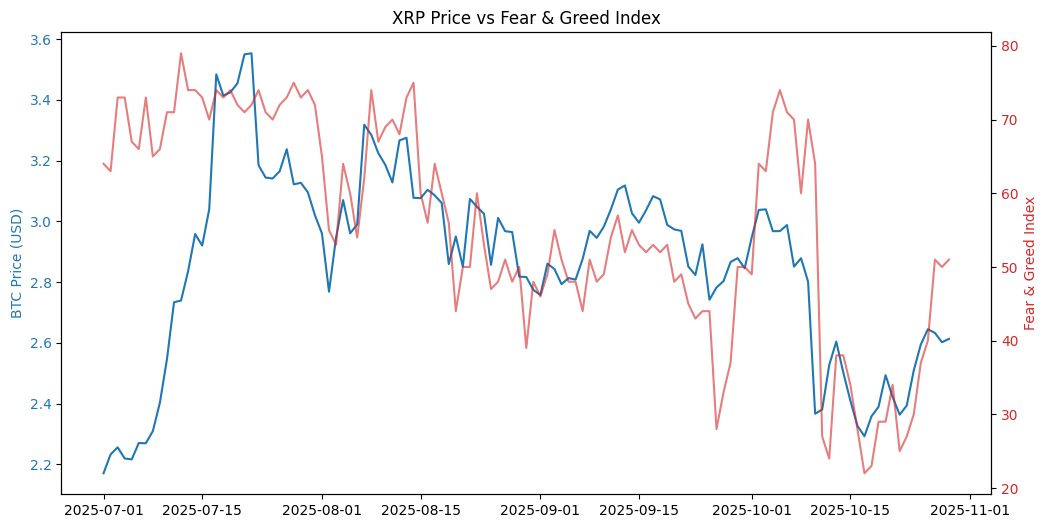

In [227]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [228]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_XRP_20250701_20251029.csv
📏 121 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\XRP\dataset_XRP_clean.csv
- data\XRP\dataset_XRP_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,2.2358,2.2532,2.1450,2.1706,607054461.5,XRP,1.334364e+09,1928888,0.000071,...,NaN,9.565687e+08,452266.114286,5.439404e+07,17,1d,NaN,NaN,0.000000,45.2
1,2025-07-02,2.1706,2.2935,2.1554,2.2328,749618585.4,XRP,1.670573e+09,2047358,-0.000017,...,NaN,8.895480e+08,366147.000000,5.280341e+07,19,1d,2.865567,0.028253,0.044984,45.4
2,2025-07-03,2.2329,2.3137,2.2238,2.2560,685093843.3,XRP,1.557045e+09,2052648,0.000100,...,NaN,9.565687e+08,452266.114286,5.439404e+07,22,1d,1.039054,0.010337,0.061763,52.6
3,2025-07-04,2.2560,2.2670,2.1941,2.2194,442260577.0,XRP,9.841967e+08,1425424,0.000088,...,NaN,9.565687e+08,452266.114286,5.439404e+07,16,1d,-1.622340,-0.016356,0.035293,50.2
4,2025-07-05,2.2194,2.2327,2.2001,2.2163,212115858.4,XRP,4.703291e+08,809014,0.000014,...,NaN,9.128041e+08,427456.000000,5.345322e+07,13,1d,-0.139677,-0.001398,0.033051,45.4


In [229]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_XRP_clean.csv
📏 121 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\XRP\dataset_XRP_clean.csv
- data\XRP\dataset_XRP_clean.xlsx
📈 Tổng số dòng sau xử lý: 121



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,2.2358,2.2532,2.1450,2.1706,607054461.5,XRP,1.334364e+09,1928888,0.000071,...,NaN,9.565687e+08,452266.114286,5.439404e+07,17,1d,NaN,NaN,0.000000,45.2
1,2025-07-02,2.1706,2.2935,2.1554,2.2328,749618585.4,XRP,1.670573e+09,2047358,-0.000017,...,NaN,8.895480e+08,366147.000000,5.280341e+07,19,1d,2.865567,0.028253,0.044984,45.4
2,2025-07-03,2.2329,2.3137,2.2238,2.2560,685093843.3,XRP,1.557045e+09,2052648,0.000100,...,NaN,9.565687e+08,452266.114286,5.439404e+07,22,1d,1.039054,0.010337,0.061763,52.6
3,2025-07-04,2.2560,2.2670,2.1941,2.2194,442260577.0,XRP,9.841967e+08,1425424,0.000088,...,NaN,9.565687e+08,452266.114286,5.439404e+07,16,1d,-1.622340,-0.016356,0.035293,50.2
4,2025-07-05,2.2194,2.2327,2.2001,2.2163,212115858.4,XRP,4.703291e+08,809014,0.000014,...,NaN,9.128041e+08,427456.000000,5.345322e+07,13,1d,-0.139677,-0.001398,0.033051,45.4


# Gộp các dữ liệu lại.

In [230]:
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]   # ⚙️ Thêm hoặc bớt coin tùy bạn
# ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"

In [231]:
# Cell 1️⃣1️⃣: Gộp tất cả dataset _clean thành 1 file tổng trong thư mục data/

def combine_clean_datasets(coin_list):
    """
    Gộp các file _clean.csv của danh sách coin thành 1 DataFrame lớn.
    Lưu file tổng ngay trong thư mục 'data/'.
    """
    all_dfs = []

    for coin in coin_list:
        data_dir = os.path.join("data", coin)
        clean_files = glob.glob(os.path.join(data_dir, f"dataset_{coin}_clean.csv"))

        if not clean_files:
            print(f"⚠️ Không tìm thấy file clean cho {coin}")
            continue

        latest_file = sorted(clean_files, key=os.path.getmtime)[-1]
        print(f"📂 Đang đọc: {os.path.basename(latest_file)}")
        df = pd.read_csv(latest_file)

        # Bổ sung cột symbol nếu thiếu
        if "symbol" not in df.columns:
            df["symbol"] = coin

        all_dfs.append(df)
        print(f"✅ {coin}: {df.shape[0]} dòng, {df.shape[1]} cột")

    if not all_dfs:
        print("❌ Không có file nào để gộp.")
        return None

    # Gộp & sắp xếp
    df_total = pd.concat(all_dfs, ignore_index=True)
    df_total = df_total.sort_values(["symbol", "Date"]).reset_index(drop=True)

    print(f"\n📊 Tổng cộng {df_total.shape[0]} dòng từ {len(all_dfs)} đồng coin.")
    print(f"📈 Các đồng được gộp: {', '.join(coin_list)}")

    # Xuất file tổng trong thư mục data/
    out_csv = os.path.join("data", "dataset_total_clean.csv")

    df_total.to_csv(out_csv, index=False)
    #df_total.to_excel(out_xlsx, index=False)

    print(f"💾 Đã lưu file tổng:\n- {out_csv}")
    return df_total


# --- Chạy chính ---
df_total = combine_clean_datasets(coin_list)
df_total.head()


📂 Đang đọc: dataset_BTC_clean.csv
✅ BTC: 121 dòng, 21 cột
📂 Đang đọc: dataset_ETH_clean.csv
✅ ETH: 121 dòng, 21 cột
📂 Đang đọc: dataset_BNB_clean.csv
✅ BNB: 121 dòng, 21 cột
📂 Đang đọc: dataset_SOL_clean.csv
✅ SOL: 121 dòng, 21 cột
📂 Đang đọc: dataset_XRP_clean.csv
✅ XRP: 121 dòng, 21 cột

📊 Tổng cộng 605 dòng từ 5 đồng coin.
📈 Các đồng được gộp: BTC, ETH, BNB, SOL, XRP
💾 Đã lưu file tổng:
- data\dataset_total_clean.csv


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2025-07-01,656.99,659.20,643.65,646.11,291724.16,BNB,1.897167e+08,473313,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,65,1d,NaN,NaN,0.000000,64.4
1,2025-07-02,646.12,664.88,643.50,659.97,382879.99,BNB,2.519876e+08,561589,0.0,...,NaN,8.895480e+08,366147.000000,5.280341e+07,62,1d,2.145146,0.021225,0.020977,62.6
2,2025-07-03,659.96,665.00,656.56,663.90,307349.05,BNB,2.032212e+08,528793,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,61,1d,0.595482,0.005937,0.026925,68.2
3,2025-07-04,663.90,664.40,650.08,653.39,287088.14,BNB,1.884732e+08,498467,0.0,...,NaN,9.565687e+08,452266.114286,5.439404e+07,59,1d,-1.583070,-0.015957,0.011018,67.4
4,2025-07-05,653.38,656.76,651.72,655.99,151159.11,BNB,9.894586e+07,300244,0.0,...,NaN,9.128041e+08,427456.000000,5.345322e+07,61,1d,0.397925,0.003971,0.014953,64.6


In [232]:
# Cell 1️⃣1️⃣b: Đổi tên các cột cho đồng nhất & dễ đọc

import os
import pandas as pd

file_path = "data/dataset_total_clean.csv"

# Đọc dữ liệu
df = pd.read_csv(file_path)
print(f"📂 Đã đọc file: {file_path}")
print(f"📏 Trước đổi tên: {df.shape[1]} cột")

# 🧩 Đổi tên các cột mong muốn
rename_map = {
    "fetch_fear_greed": "fear_greed_index",
    "google_interest": "google_trend_score",
    "Close_norm": "close_norm",
    "active_addresses": "onchain_active_addresses"
}

# Chỉ đổi nếu cột tồn tại
existing = [c for c in rename_map.keys() if c in df.columns]
df = df.rename(columns={k: rename_map[k] for k in existing})

print(f"✅ Đã đổi tên {len(existing)} cột:")
for old, new in rename_map.items():
    if old in existing:
        print(f"   • {old} → {new}")



if 'onchain_active_addresses' in df.columns:
    df = df.drop(columns=['onchain_active_addresses'])

# Điền giá trị nhỏ còn thiếu
df['log_return'] = df['log_return'].ffill()
df['pct_change'] = df['pct_change'].ffill()


# 💾 Lưu lại — bạn có thể chọn:
SAVE_OVERWRITE = True   # ⚙️ Đổi thành False nếu muốn lưu bản mới

if SAVE_OVERWRITE:
    out_csv = file_path
    #out_xlsx = "data/dataset_total_clean.xlsx"
else:
    out_csv = "data/dataset_total_clean_renamed.csv"
    #out_xlsx = "data/dataset_total_clean_renamed.xlsx"

df.to_csv(out_csv, index=False)
#df.to_excel(out_xlsx, index=False)

print(f"💾 Đã lưu lại:\n- {out_csv}")
print("\n📑 Danh sách cột sau khi đổi tên:")
print(df.columns.tolist()[:15], "...")


📂 Đã đọc file: data/dataset_total_clean.csv
📏 Trước đổi tên: 21 cột
✅ Đã đổi tên 4 cột:
   • fetch_fear_greed → fear_greed_index
   • google_interest → google_trend_score
   • Close_norm → close_norm
   • active_addresses → onchain_active_addresses
💾 Đã lưu lại:
- data/dataset_total_clean.csv

📑 Danh sách cột sau khi đổi tên:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol', 'Quote_Volume', 'Number_Of_Trades', 'funding_Rate', 'fear_greed_index', 'hash_rate', 'tx_count', 'miners_revenue', 'google_trend_score'] ...


In [8]:
# Danh sách coin hoặc thư mục bạn muốn dọn
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]

for coin in coin_list:
    folder = os.path.join("data", coin)
    if not os.path.exists(folder):
        print(f"⚠️ Thư mục {folder} không tồn tại, bỏ qua.")
        continue

    for f in glob.glob(os.path.join(folder, "*")):
        # Giữ lại duy nhất file "_clean.csv"
        if f.endswith("_clean.csv"):
            continue
        try:
            os.remove(f)
            print(f"Đã xóa: {f}")
        except Exception as e:
            print(f"❌ Không thể xóa {f}: {e}")

print("\n✅ Dọn dẹp hoàn tất! Chỉ còn lại file _clean.csv trong từng thư mục coin.")



✅ Dọn dẹp hoàn tất! Chỉ còn lại file _clean.csv trong từng thư mục coin.


# Tiền xử lý dữ liệu

In [6]:
import pandas as pd

df = pd.read_csv("data/dataset_total_clean.csv")

# Ép kiểu sang số để ffill hoạt động đúng
df['pct_change'] = pd.to_numeric(df['pct_change'], errors='coerce')
df['log_return'] = pd.to_numeric(df['log_return'], errors='coerce')

# Điền phần bị thiếu
df['pct_change'] = df['pct_change'].ffill()
df['log_return'] = df['log_return'].ffill()

# 💾 Ghi đè lên file cũ
out_csv = "data/dataset_total_clean.csv"
df.to_csv(out_csv, index=False)

print(f"✅ Đã fill giá trị và ghi đè lại file: {out_csv}")
print(df[['symbol','Date','pct_change','log_return']].head(10))


✅ Đã fill giá trị và ghi đè lại file: data/dataset_total_clean.csv
  symbol        Date  pct_change  log_return
0    BNB  2025-07-01         NaN         NaN
1    BNB  2025-07-02    2.145146    0.021225
2    BNB  2025-07-03    0.595482    0.005937
3    BNB  2025-07-04   -1.583070   -0.015957
4    BNB  2025-07-05    0.397925    0.003971
5    BNB  2025-07-06    1.086907    0.010810
6    BNB  2025-07-07   -0.313669   -0.003142
7    BNB  2025-07-08   -0.078664   -0.000787
8    BNB  2025-07-09    1.265669    0.012577
9    BNB  2025-07-10    2.604354    0.025710


**Scale dữ liệu cho từng symbol trước**

In [9]:
# =====================================================
# 🧩 SCALE RIÊNG TỪNG COIN & LƯU VỀ THƯ MỤC CỦA NÓ
# =====================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# --- 1️⃣ Đọc dữ liệu tổng ---
df = pd.read_csv("data/dataset_total_clean.csv")
print(f"📂 Đã đọc file tổng: {df.shape[0]} dòng, {df.shape[1]} cột")

# --- 2️⃣ Xác định các cột numeric cần scale ---
num_cols = [
    'Open','High','Low','Close','Volume',
    'funding_Rate','hash_rate','tx_count',
    'miners_revenue','sentiment_mix','google_trend_score'
]

# --- 3️⃣ Kiểm tra cột có tồn tại trước khi scale ---
num_cols = [c for c in num_cols if c in df.columns]
print(f"🔍 Cột sẽ được scale: {num_cols}")

# --- 4️⃣ Scale riêng từng symbol ---
scaled_dfs = []

for sym in df['symbol'].unique():
    subset = df[df['symbol'] == sym].copy()
    
    # Scale riêng từng coin
    scaler = StandardScaler()
    subset[num_cols] = scaler.fit_transform(subset[num_cols])
    
    # Tạo thư mục lưu
    coin_dir = f"data/{sym}"
    os.makedirs(coin_dir, exist_ok=True)
    
    # Đường dẫn lưu
    out_path = os.path.join(coin_dir, f"dataset_{sym}_scaled.csv")
    subset.to_csv(out_path, index=False)
    
    scaled_dfs.append(subset)
    print(f"✅ {sym}: Đã scale & lưu → {out_path}")

# --- 5️⃣ Gộp lại thành 1 file tổng sau khi scale ---
df_scaled_total = pd.concat(scaled_dfs, ignore_index=True)
out_total = "data/dataset_scaled_total.csv"
df_scaled_total.to_csv(out_total, index=False)

print("\n💾 Hoàn tất scale toàn bộ:")
print(f"   ├─ Đã lưu riêng từng coin trong thư mục data/<symbol>/")
print(f"   └─ File tổng sau scale: {out_total}")
print(f"📏 Tổng dòng sau scale: {df_scaled_total.shape[0]}")


📂 Đã đọc file tổng: 605 dòng, 20 cột
🔍 Cột sẽ được scale: ['Open', 'High', 'Low', 'Close', 'Volume', 'funding_Rate', 'hash_rate', 'tx_count', 'miners_revenue', 'sentiment_mix', 'google_trend_score']
✅ BNB: Đã scale & lưu → data/BNB\dataset_BNB_scaled.csv
✅ BTC: Đã scale & lưu → data/BTC\dataset_BTC_scaled.csv
✅ ETH: Đã scale & lưu → data/ETH\dataset_ETH_scaled.csv
✅ SOL: Đã scale & lưu → data/SOL\dataset_SOL_scaled.csv
✅ XRP: Đã scale & lưu → data/XRP\dataset_XRP_scaled.csv

💾 Hoàn tất scale toàn bộ:
   ├─ Đã lưu riêng từng coin trong thư mục data/<symbol>/
   └─ File tổng sau scale: data/dataset_scaled_total.csv
📏 Tổng dòng sau scale: 605


# Data Visualization

## --- Setup ---

In [11]:
# --- Setup ---
os.makedirs("data/picture", exist_ok=True)

df_clean = pd.read_csv("data/dataset_total_clean.csv")
df_scaled = pd.read_csv("data/dataset_scaled_total.csv")

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 5)

## BIỂU ĐỒ CHUNG CHO 5 COIN

### Waffle Chart: Tỷ trọng volume

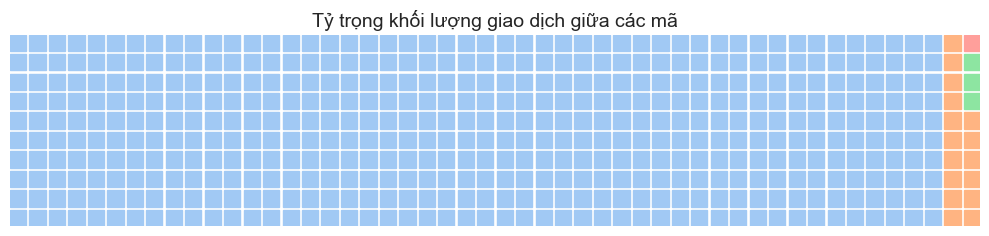

In [14]:
# --- Waffle Chart: Tỷ trọng volume ---
symbol_share = df_clean.groupby('symbol')['Volume'].sum().sort_values(ascending=False)
scaled_share = (symbol_share / symbol_share.sum() * 500).round(2)

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=scaled_share,
    title={'label': 'Tỷ trọng khối lượng giao dịch giữa các mã', 'loc': 'center', 'fontsize': 14},
    colors=sns.color_palette('pastel', n_colors=len(scaled_share)),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.savefig("data/picture/waffle_volume_share.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()


### Bar Chart: Giá trung bình Close

C:\Users\chand\AppData\Local\Temp\ipykernel_8336\1618607605.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='symbol', y='Close', data=df_clean, ci=None, palette='viridis')
C:\Users\chand\AppData\Local\Temp\ipykernel_8336\1618607605.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='symbol', y='Close', data=df_clean, ci=None, palette='viridis')


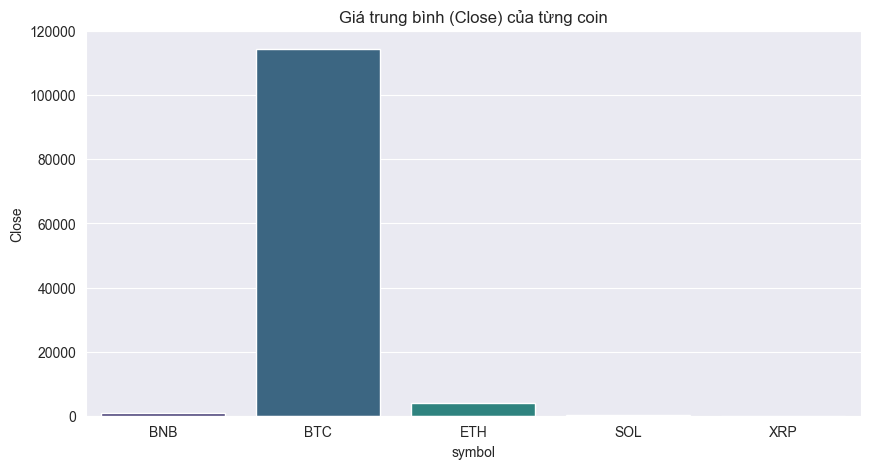

In [15]:
plt.figure()
sns.barplot(x='symbol', y='Close', data=df_clean, ci=None, palette='viridis')
plt.title("Giá trung bình (Close) của từng coin")
plt.savefig("data/picture/bar_avg_close.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Pie Chart: miners_revenue

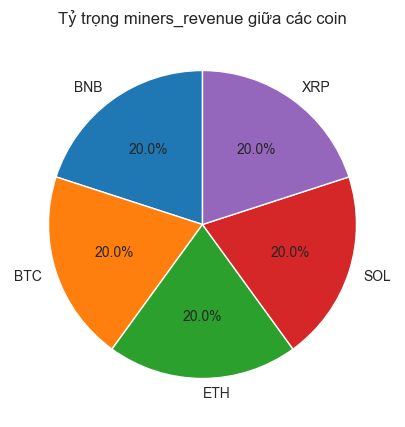

In [16]:
plt.figure()
miner_sum = df_clean.groupby('symbol')['miners_revenue'].sum()
plt.pie(miner_sum, labels=miner_sum.index, autopct='%1.1f%%', startangle=90)
plt.title("Tỷ trọng miners_revenue giữa các coin")
plt.savefig("data/picture/pie_miner_revenue.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Area Chart: Close theo thời gian

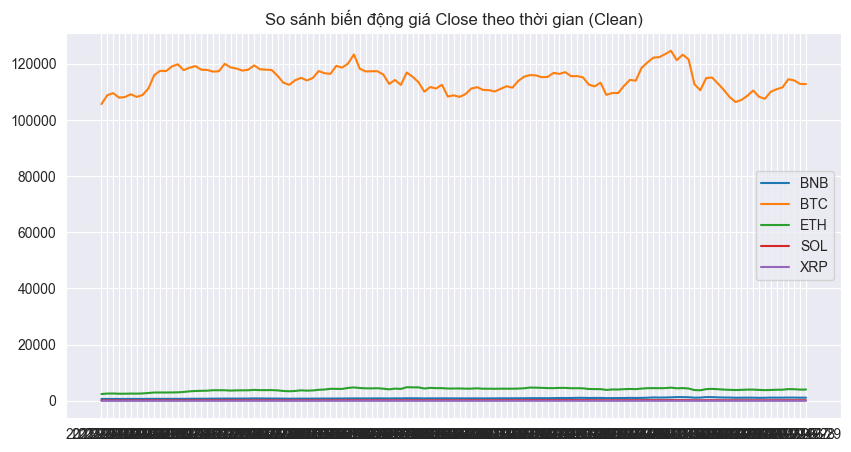

In [17]:
plt.figure()
for sym in df_clean['symbol'].unique():
    df_sub = df_clean[df_clean['symbol'] == sym]
    plt.plot(df_sub['Date'], df_sub['Close'], label=sym)
plt.legend()
plt.title("So sánh biến động giá Close theo thời gian (Clean)")
plt.savefig("data/picture/area_close_all.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

## BIỂU ĐỒ CHI TIẾT TỪNG COIN

In [24]:
# Giả sử bạn đã có df_clean và df_scaled sẵn
# df_clean = pd.read_csv("data/dataset_total_clean.csv")
# df_scaled = pd.read_csv("data/dataset_scaled_total.csv")

for sym in df_clean['symbol'].unique():
    os.makedirs(f"data/{sym}/pic", exist_ok=True)

    df_c = df_clean[df_clean['symbol'] == sym]
    df_s = df_scaled[df_scaled['symbol'] == sym]

    # --- Histogram ---
    plt.figure()
    sns.histplot(df_c['log_return'], kde=True, bins=20)
    plt.title(f"{sym}: Phân bố log_return (Clean)")
    plt.savefig(f"data/{sym}/pic/hist_log_return.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Scatter ---
    plt.figure()
    sns.scatterplot(x='funding_Rate', y='Close', data=df_c)
    plt.title(f"{sym}: Funding Rate vs Close (Clean)")
    plt.savefig(f"data/{sym}/pic/scatter_funding_vs_close.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Area Chart ---
    plt.figure()
    plt.fill_between(df_c['Date'], df_c['Close'], alpha=0.5)
    plt.title(f"{sym}: Biến động giá Close (Clean)")
    plt.savefig(f"data/{sym}/pic/area_close.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Bar Chart ---
    df_c = df_c.copy()
    df_c['Date'] = pd.to_datetime(df_c['Date'], errors='coerce')  # ép chuyển datetime
    df_c['week'] = df_c['Date'].apply(lambda x: x.isocalendar().week if pd.notnull(x) else np.nan)


    weekly = df_c.groupby('week')['Volume'].mean()
    plt.figure()
    sns.barplot(x=weekly.index, y=weekly.values, color='skyblue')
    plt.title(f"{sym}: Volume trung bình theo tuần")
    plt.savefig(f"data/{sym}/pic/bar_weekly_volume.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Pie Chart (Scaled - MinMax absolute values) ---
    plt.figure()
    feat_avg = df_s[['Open','High','Low','Close','Volume']].mean().abs().values.reshape(-1, 1)

    # Scale lại 0–1 để biểu đồ có tỷ lệ hợp lý
    scaler = MinMaxScaler()
    feat_scaled = scaler.fit_transform(feat_avg).flatten()

    plt.pie(feat_scaled, labels=['Open','High','Low','Close','Volume'], autopct='%1.1f%%')
    plt.title(f"{sym}: Tỷ trọng trung bình các biến chính (Scaled - MinMax)")
    plt.savefig(f"data/{sym}/pic/pie_features_scaled.png", bbox_inches='tight', dpi=300)
    plt.close()

print("✅ Đã tạo toàn bộ biểu đồ cho cả dữ liệu Clean và Scaled (Pie Chart fix bằng MinMaxScaler).")


✅ Đã tạo toàn bộ biểu đồ cho cả dữ liệu Clean và Scaled (Pie Chart fix bằng MinMaxScaler).


# ...........................................................................................................................

In [25]:
import os

def print_tree(start_path=".", indent=""):
    for item in os.listdir(start_path):
        path = os.path.join(start_path, item)
        if os.path.isdir(path):
            print(indent + "📁 " + item)
            print_tree(path, indent + "    ")
        else:
            print(indent + "📄 " + item)

# 🔧 Chạy hàm này ở thư mục gốc dự án (nơi chứa index.html, data/, api/...)
print_tree(".")


📁 assets
    📁 css
        📄 style.css
📁 data
    📁 BNB
        📄 dataset_BNB_clean.csv
        📄 dataset_BNB_scaled.csv
        📁 pic
            📄 area_close.png
            📄 bar_weekly_volume.png
            📄 hist_log_return.png
            📄 pie_features_scaled.png
            📄 scatter_funding_vs_close.png
    📁 BTC
        📄 dataset_BTC_clean.csv
        📄 dataset_BTC_scaled.csv
        📁 pic
            📄 area_close.png
            📄 bar_weekly_volume.png
            📄 hist_log_return.png
            📄 pie_features_scaled.png
            📄 scatter_funding_vs_close.png
    📄 dataset_scaled_total.csv
    📄 dataset_total_clean.csv
    📁 ETH
        📄 dataset_ETH_clean.csv
        📄 dataset_ETH_scaled.csv
        📁 pic
            📄 area_close.png
            📄 bar_weekly_volume.png
            📄 hist_log_return.png
            📄 pie_features_scaled.png
            📄 scatter_funding_vs_close.png
    📁 picture
        📄 area_close_all.png
        📄 bar_avg_close.png
        📄 pie_m

In [26]:
import os
import json

# 📁 Thư mục gốc chứa các folder coin
DATA_DIR = "data"
OUT_PATH = os.path.join(DATA_DIR, "picture", "manifest.json")

# 🧩 Các từ khóa nhận diện loại biểu đồ (đặt tên gợi ý cho AI / web)
chart_keywords = {
    "area": "price_trend",
    "bar": "volume_weekly",
    "hist": "volatility",
    "pie": "composition",
    "scatter": "funding_vs_close",
}

manifest = {}

# --- Quét toàn bộ thư mục data/ ---
for symbol in os.listdir(DATA_DIR):
    coin_path = os.path.join(DATA_DIR, symbol)
    if not os.path.isdir(coin_path) or symbol.lower() == "picture":
        continue

    pic_path = os.path.join(coin_path, "pic")
    if not os.path.exists(pic_path):
        continue

    charts = {}
    for file in os.listdir(pic_path):
        if file.endswith(".png"):
            name, _ = os.path.splitext(file)
            # Xác định loại biểu đồ dựa theo từ khóa trong tên file
            matched = next((v for k, v in chart_keywords.items() if k in name.lower()), name)
            rel_path = os.path.join("data", symbol, "pic", file).replace("\\", "/")
            charts[matched] = rel_path

    manifest[symbol.upper()] = {"charts": charts}

# --- Lưu manifest ra file JSON ---
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=4, ensure_ascii=False)

print(f"✅ Đã tạo manifest.json tại: {OUT_PATH}")
print(f"📊 Tổng số coin: {len(manifest)}")
print(json.dumps(manifest, indent=2, ensure_ascii=False))


✅ Đã tạo manifest.json tại: data\picture\manifest.json
📊 Tổng số coin: 5
{
  "BNB": {
    "charts": {
      "price_trend": "data/BNB/pic/area_close.png",
      "volume_weekly": "data/BNB/pic/bar_weekly_volume.png",
      "volatility": "data/BNB/pic/hist_log_return.png",
      "composition": "data/BNB/pic/pie_features_scaled.png",
      "funding_vs_close": "data/BNB/pic/scatter_funding_vs_close.png"
    }
  },
  "BTC": {
    "charts": {
      "price_trend": "data/BTC/pic/area_close.png",
      "volume_weekly": "data/BTC/pic/bar_weekly_volume.png",
      "volatility": "data/BTC/pic/hist_log_return.png",
      "composition": "data/BTC/pic/pie_features_scaled.png",
      "funding_vs_close": "data/BTC/pic/scatter_funding_vs_close.png"
    }
  },
  "ETH": {
    "charts": {
      "price_trend": "data/ETH/pic/area_close.png",
      "volume_weekly": "data/ETH/pic/bar_weekly_volume.png",
      "volatility": "data/ETH/pic/hist_log_return.png",
      "composition": "data/ETH/pic/pie_features_scale